#Downloads

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-11-27 03:56:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-27 03:56:17 (65.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



#Imports

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from helper_functions import calculate_results,plot_loss_curves
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization
import os

#Preprocessing

In [4]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

##get_lines()

In [6]:
def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()


In [7]:
train_lines=get_lines(data_dir + "train.txt")

##Preprocess_text_with_line_numbers

In [8]:
def preprocess_text_with_line_numbers(filename):
  input_lines=get_lines(filename)
  abstract_lines=""
  abstract_samples=[]

  for line in input_lines:
    if line.startswith("###"):
      abstract_id=line
      abstract_lines=""
    elif line.isspace():
      abstract_line_split=abstract_lines.splitlines()
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_text_split=abstract_line.split("\t")
        line_data["target"]=target_text_split[0]
        line_data["text"]=target_text_split[1].lower()
        line_data["line_number"]=abstract_line_number
        line_data["total_lines"]=len(abstract_line_split)
        abstract_samples.append(line_data)
    else:
      abstract_lines+=line
  return abstract_samples


In [9]:
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")

In [10]:
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)


In [11]:
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()

##OneHot Encoding

In [12]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

##Label Encoding

In [13]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())


In [14]:
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_

##Mean Sentence Length

In [22]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)

##Output seq len

In [23]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

##Loading into chars

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

##Mean char len

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)

##Split chars

In [ ]:
def split_chars(text):
  return " ".join(list(text))


In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#Create Text Vectorizer

In [15]:
max_tokens = 68000

In [16]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [17]:
text_vectorizer.adapt(train_sentences)

##Testing the Text Vectorizer

In [26]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
to evaluate hepatic fat fraction on dual - and triple-echo gradient-recalled echo mri sequences in healthy children .

Length of text: 18

Vectorized text:
[[    6   164  1668   590  1015    18  1833     3 17754 56853 10780   975
   3838     5   247   109     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [24]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#Embedding

In [ ]:
len(rct_20k_text_vocab)

64841

In [27]:

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                output_dim=64,
                                mask_zero=True,
                                name="token_embedding")
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
to evaluate hepatic fat fraction on dual - and triple-echo gradient-recalled echo mri sequences in healthy children .

Sentence after vectorization (before embedding):
[[    6   164  1668   590  1015    18  1833     3 17754 56853 10780   975
   3838     5   247   109     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.02692462 -0.01722961  0.02236067 ... -0.03029189 -0.04800672
   -0.03616432]
  [-0.03322037 -0.01296698 -0.01964017 ...  0.00770419 -0.01560892
    0.01627716]
  [-0.01456647  0.011124    0.01977434 ... -0.03935654  0.00310902
    0.04702122]
  ...
  [ 0.00590819  0.02222817  0.04956442 ...  0.01102187 -0.03446943
    0.01890503]
  [ 0.00590819  0.02222817  0.04956442 ...  0.01102187 -0.03446943
    0.01890503]
  [ 0.00590

#Converting datasets into td.data Datasets using tf.data API

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

#Output char len

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

#Strings

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

##Character Vectorizer


In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2

In [ ]:
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [ ]:
char_vectorizer.adapt(train_chars)

##Character Embedding

In [ ]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

##Conv1D Model on CHaracter Embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d (Conv1D)             (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 5

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 6ms/step - loss: 1.2750 - accuracy: 0.4839 - val_loss: 1.0432 - val_accuracy: 0.5951
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0014 - accuracy: 0.5978 - val_loss: 0.9327 - val_accuracy: 0.6307
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9188 - accuracy: 0.6407 - val_loss: 0.8592 - val_accuracy: 0.6729


In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.8779 - accuracy: 0.6616


[0.8779230713844299, 0.6616244912147522]

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.18144365, 0.45477003, 0.05299162, 0.28771752, 0.02307709],
       [0.3907318 , 0.47005332, 0.01247702, 0.10000787, 0.02673005],
       [0.23198026, 0.22951554, 0.16184609, 0.3300689 , 0.04658924],
       ...,
       [0.00640915, 0.01621056, 0.02653512, 0.00230517, 0.94854003],
       [0.02836484, 0.0591562 , 0.5730153 , 0.02704549, 0.31241822],
       [0.2770458 , 0.5029553 , 0.10813028, 0.07609344, 0.03577511]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 66.1624520058255,
 'precision': 0.6573369832991327,
 'recall': 0.661624520058255,
 'f1': 0.648054138668622}

#Model 0 (TF-IDF Baseline using MultinomialNB)

In [21]:
model_0=Pipeline([
    ("tf-idf ",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [ ]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

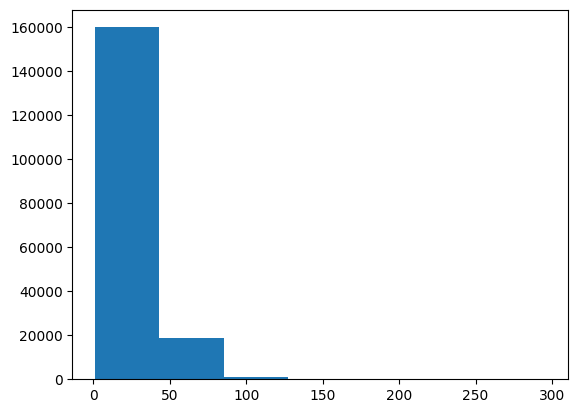

In [ ]:
plt.hist(sent_lens, bins=7);

#Model - 1

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)


model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

#Model-2

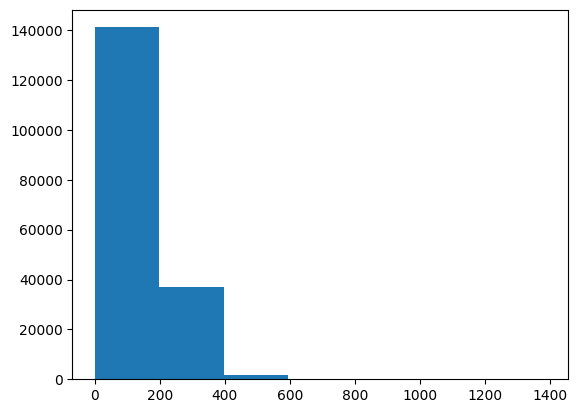

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

#Model 3 (Hybrid Embeddings)

In [ ]:
# import tensorflow_hub as hub
# tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
#                                         trainable=False,
#                                         name="universal_sentence_encoder")

In [39]:
token_inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(token_inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

In [40]:
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [ ]:
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

ValueError: ignored

In [ ]:
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [ ]:
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

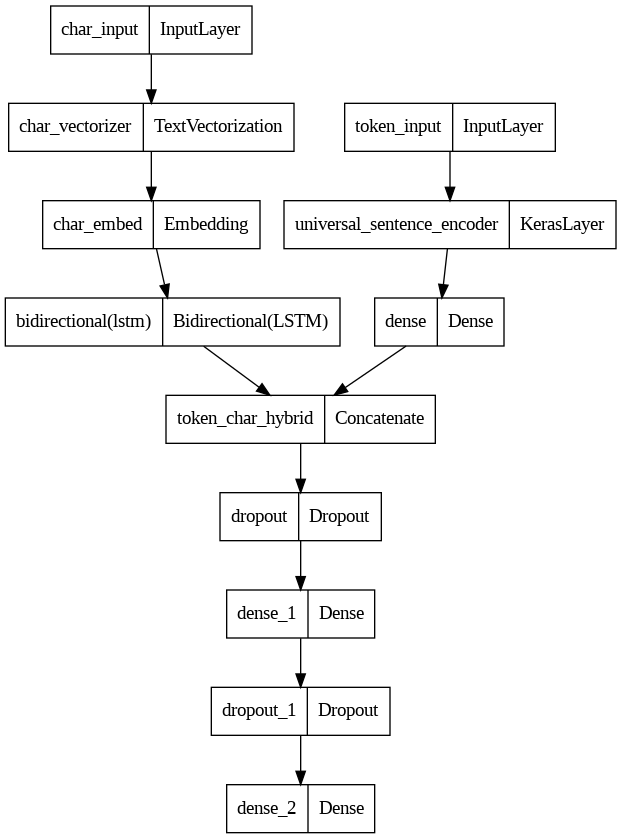

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 43ms/step - loss: 0.9750 - accuracy: 0.6101 - val_loss: 0.7802 - val_accuracy: 0.6975
Epoch 2/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7922 - accuracy: 0.6953 - val_loss: 0.7195 - val_accuracy: 0.7234
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7735 - accuracy: 0.7033 - val_loss: 0.6970 - val_accuracy: 0.7324


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6995 - accuracy: 0.7337


[0.6995431780815125, 0.733748197555542]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 20s 20ms/step


{'accuracy': 73.37481795313121,
 'precision': 0.7351529707337144,
 'recall': 0.7337481795313121,
 'f1': 0.7312152558775492}

#Model-5(Tribid Model)

##Positional Embeddings

In [64]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [65]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

##Token inputs

In [98]:
token_inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(token_inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors)
# x = layers.Conv1D(128,kernel_size=5,padding='same',activation="relu")(token_embeddings)
x=layers.Dense(128,activation="relu",name="Input_dense")(token_embeddings)
# x=layers.Dropout(0.2)(x)
x = layers.GlobalMaxPool1D()(x)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=x)

In [74]:
token_model.output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'global_max_pooling1d_7')>

##Character inputs

In [99]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)

x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
char_model = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

In [46]:
char_model.output

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_3')>

##Line number inputs

In [100]:
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

##Total Lines Input

In [101]:
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

##Combining text and char embedding

In [ ]:
char_model.output.shape

TensorShape([None, 64])

In [102]:
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

##Combining the combined embedding with Positional embeddings

In [103]:
z1 = layers.Concatenate(name="token_char_positional_embedding_2")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])


In [104]:
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z1)

##Model-5

In [105]:
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [60]:
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['input_4[0][0]']             
 rization)                                                                                        
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['input_8[0][0]']       

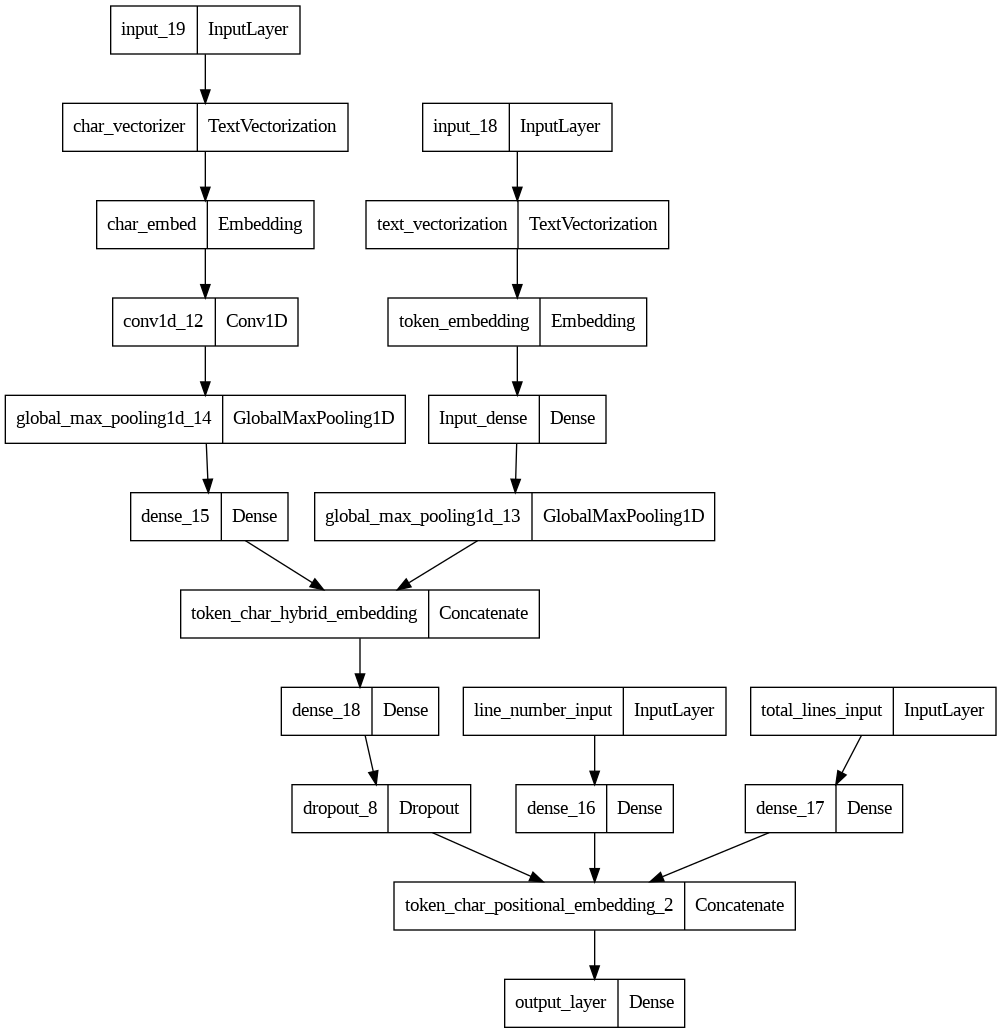

In [106]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [107]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [108]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [109]:
checkpoint_path = "DataMap_model_5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True)

In [110]:
history_model_5_2 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(len(train_pos_char_token_dataset)),
                              epochs=10,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(len(val_pos_char_token_dataset)),
                              callbacks=checkpoint_callback)

Epoch 1/10
5627/5627 [==============================] - 87s 15ms/step - loss: 0.8820 - accuracy: 0.8819 - val_loss: 0.9078 - val_accuracy: 0.8532
Epoch 2/10
5627/5627 [==============================] - 63s 11ms/step - loss: 0.8228 - accuracy: 0.9232 - val_loss: 0.9245 - val_accuracy: 0.8426
Epoch 3/10
5627/5627 [==============================] - 64s 11ms/step - loss: 0.7993 - accuracy: 0.9397 - val_loss: 0.9346 - val_accuracy: 0.8386
Epoch 4/10
5627/5627 [==============================] - 69s 12ms/step - loss: 0.7835 - accuracy: 0.9508 - val_loss: 0.9415 - val_accuracy: 0.8335
Epoch 5/10
5627/5627 [==============================] - 64s 11ms/step - loss: 0.7725 - accuracy: 0.9582 - val_loss: 0.9547 - val_accuracy: 0.8270
Epoch 6/10
5627/5627 [==============================] - 63s 11ms/step - loss: 0.7644 - accuracy: 0.9633 - val_loss: 0.9494 - val_accuracy: 0.8281
Epoch 7/10
5627/5627 [==============================] - 62s 11ms/step - loss: 0.7578 - accuracy: 0.9671 - val_loss: 0.9593 -

In [80]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(len(train_pos_char_token_dataset)),
                              epochs=10,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(len(val_pos_char_token_dataset)),
                              callbacks=checkpoint_callback)

Epoch 1/10
5627/5627 [==============================] - 62s 11ms/step - loss: 0.7120 - accuracy: 0.9921 - val_loss: 0.9433 - val_accuracy: 0.8381
Epoch 2/10
1507/5627 [=======>......................] - ETA: 42s - loss: 0.7101 - accuracy: 0.9926

KeyboardInterrupt: ignored

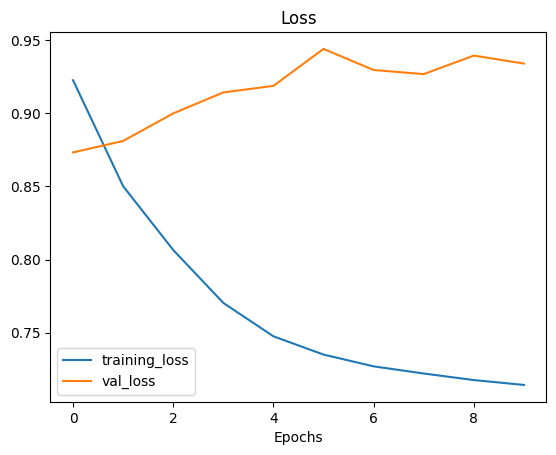

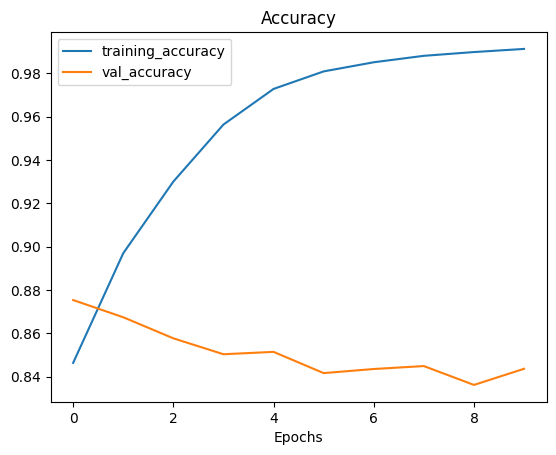

In [79]:
plot_loss_curves(history_model_5)

In [ ]:
history_model_5_2 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(len(train_pos_char_token_dataset)),
                              epochs=20,
                              initial_epoch=history_model_5.epoch[-1],
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(len(val_pos_char_token_dataset)),
                              callbacks=checkpoint_callback)

In [ ]:
model_5.save("DataMap_tribid")

#Mounted Gdrive

In [76]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = f"/content/gdrive/My Drive/model_5(85)"
model_5.save(path)

In [118]:
import pickle
with open('model_6.pkl', 'wb') as file:
    pickle.dump(model_5, file)

#Weird exp

In [78]:
!du model_5.pkl

51072	model_5.pkl


In [ ]:
!mkdir model_5

In [ ]:
!cp "/content/gdrive/MyDrive/model_5(85)" -r model_5

In [ ]:
!pip install joblib

In [ ]:
import joblib

In [ ]:
joblib.dump(loaded_model, 'Tribid_model_joblib.pkl')

In [ ]:
import zipfile
file_path = '/content/Tribid_model_joblib.pkl'
zip_file_name = 'Tribid_model_joblib.zip'
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    zipf.write(file_path, arcname=file_path.split('/')[-1])  # arcname sets the name inside the zip file


In [ ]:
from google.colab import files
files.download(zip_file_name)

#Loading the model using tf_hub

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "/content/model_5/model_5(85)"
loaded_model = tf.keras.models.load_model(model_path)

#Test Dataset

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)

942/942 [==============================] - 26s 24ms/step


In [ ]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 84.27409988385598,
 'precision': 0.8420188510234291,
 'recall': 0.8427409988385598,
 'f1': 0.8400975973602568}

import json
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)


#Example abstract

In [122]:
import json
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-11-27 06:11:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-11-27 06:11:25 (98.7 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [123]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


#Preprocessing the abstract

In [124]:
from spacy.lang.en import English
nlp = English()
sentencizer = nlp.add_pipe("sentencizer")


doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)]
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

##Converting it into dict

In [125]:
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

##One-hot encoding

In [126]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)

In [127]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

##Dividing into chars

In [128]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

In [120]:
with open('model_6.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
file.close()

##Predicting


In [129]:
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs


1/1 [==============================] - 0s 212ms/step


array([[0.40253165, 0.11118435, 0.24621323, 0.13607776, 0.10399308],
       [0.05413698, 0.03493536, 0.77677166, 0.0792449 , 0.05491113],
       [0.11316083, 0.08067188, 0.4254787 , 0.09798136, 0.28270727],
       [0.0993015 , 0.41046664, 0.32265618, 0.0750246 , 0.09255104],
       [0.02463488, 0.01446754, 0.03161191, 0.02399528, 0.90529037],
       [0.02413782, 0.01510166, 0.03546604, 0.02440134, 0.90089315],
       [0.02191037, 0.09264028, 0.13271222, 0.02709312, 0.725644  ],
       [0.01341921, 0.05136053, 0.01592808, 0.01363096, 0.90566117]],
      dtype=float32)

In [130]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 2, 2, 1, 4, 4, 4, 4])>

In [131]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['BACKGROUND',
 'METHODS',
 'METHODS',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS']

In [132]:
l1=[[]]
j=0
line_list=[]
dict_lines={}
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i] }: {line}")

BACKGROUND: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
CONCLUSIONS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
RESULTS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


In [ ]:
line2="hi"
line_list2=[]
line_list2.append(line2)
line_list2

['hi']

In [ ]:
tf.__version__

'2.14.0'